# SPRINT NRO 3

1. Preparación de los datos:
- Carga de datos: Cargar los conjuntos de datos en Python utilizando bibliotecas como Pandas para manipular los datos.
- Limpieza y preparación de datos: Manejar valores nulos, eliminar duplicados, transformar datos categóricos en numéricos, etc.
- Exploración de datos: Comprender la distribución de los datos, identificar relaciones entre las variables, realizar visualizaciones para obtener información útil.
2. Ingeniería de características:
Identificar y crear nuevas características que puedan ser relevantes para predecir las ventas.
Normalizar o escalar los datos si es necesario para el modelo.
3. Aplicación de modelo de series de tiempos:

- Arima:
Preparación de los Datos: Agruparemos los datos por mes. Esto se hace para obtener una serie temporal más manejable y para ayudar a revelar patrones estacionales o tendencias.

Revisión de la Estacionariedad: Realizaremos pruebas de estacionariedad, como la prueba de Dickey-Fuller aumentada, para determinar si es necesario diferenciar los datos para hacerlos estacionarios.

Identificación de los Parámetros ARIMA: Utilizaremos las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los parámetros p, d, y q del modelo ARIMA.

Ajuste del Modelo ARIMA: Ajustaremos un modelo ARIMA con los parámetros identificados a los datos. También se aplica Optuna para optimización de datos.

Predicciones: Realizaremos predicciones para los próximos años.


## Obtener datos

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
archivo3 = '/content/drive/MyDrive/PF/olist_products_dataset.csv'
df3 = pd.read_csv(archivo3)

In [ ]:
archivo5 = '/content/drive/MyDrive/PF/olist_orders_dataset.csv'
df5 = pd.read_csv(archivo5)

In [ ]:
archivo6 = '/content/drive/MyDrive/PF/olist_order_payments_dataset.csv'
df6 = pd.read_csv(archivo6)

In [ ]:
archivo7 = '/content/drive/MyDrive/PF/olist_order_items_dataset.csv'
df7 = pd.read_csv(archivo7)

## Generación de DF a modelar

### Entendimiento del valor de la orden

En df6, tabla de ordenes y pagos, se puede ver tantos valores de pago como payment_sequential.

Se puede asumir que el verdadero valor de la orden es la suma de todos los registros.

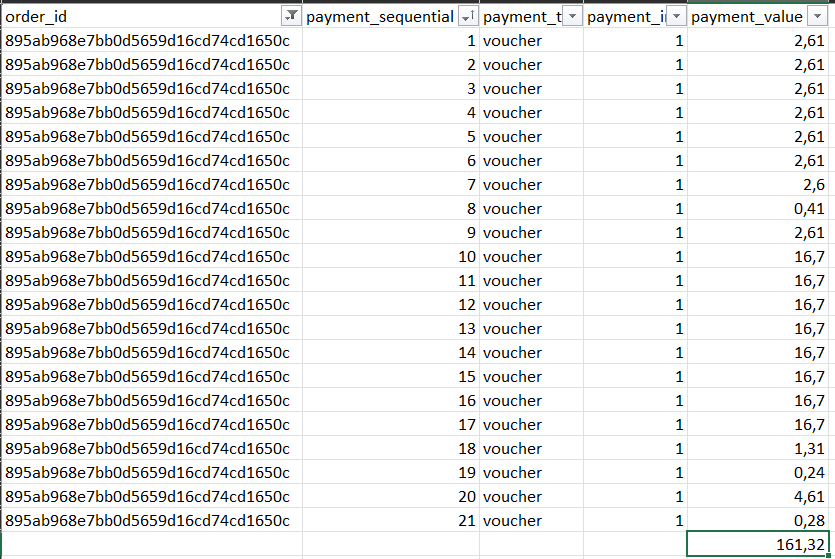

In [ ]:
df6.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


En df7, tabla de ordenes y productos, se puede entender que la orden en cuestión tiene 3 item ( 2 productos ya que uno se compró 2 veces). El valor de cada producto mas su valor de envio, da el mismo total que la orden.

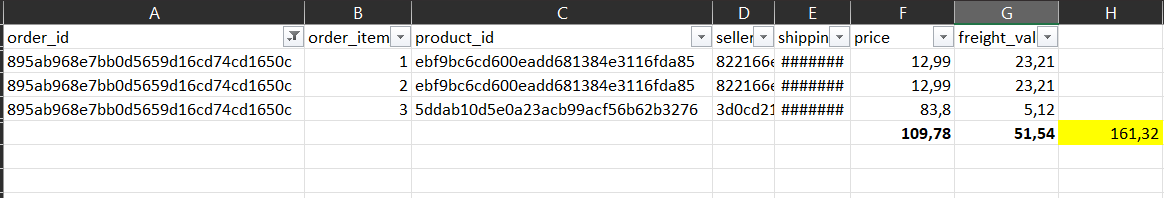

Al poder ver esto, se puede entender que:
- existen varios registros con el mismo order_id, no solo por la cantidad de diferentes productos asociados a la orden, si no tambien por las distintas "payment_sequential" con la que cuenta la orden. Cada una de ellas tiene un valor distinto en el pago (payment_installments) pero si se suman, va a dar el total de lo que se pago por producto y la suma de productos, dara el total del pago de la orden.

**Por lo tanto se decide:**

**Realizar una agrupamiento por orden y dejar el valor total unificado en una nueva variable para poder utilizarla en la predicción de ventas.**

### Entendimiento de tablas y variables a utilizar

Las tablas a utilizar para el modelo de ventas serán:

Tabla (5): olist_orders_dataset
- Variables a utilizar:
 * order_id
 * order_status: se tomarán aquellas con valor delivered y se excluirán aquellas canceled.
 *order purchase timestamp (para saber la fecha de la orden)


Tabla (6): olist_order_payments_dataset.
- Variables a utilizar:
 * order_id
 * payment sequential (para agrupar la orden y calcular el monto total)
 * payment value (será la base del monto total de la orden)

Existe dos tablas que aportan información de las ventas, pero a priori se descartan del análisis. Una de ellas contiene información de cuantos productos existen por orden y cuales productos son los comprados. La otra tiene información de las categorías de los productos.

Tabla (3): olist_products_dataset
- Variables:
 * product_id
 * product_category_name

Tabla (7): olist_order_items_dataset
- Variables:
 * order_id
 * order_item_id
 * product_id

In [ ]:
df3.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


In [ ]:
df5.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [ ]:
df6.head(1)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


In [ ]:
df7.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


### Creación de df para el modelo

Para el modelo se utilizará entonces las tablas 5 y 6.

1) Se creará una copia del df6 (ordenes y pagos) para agrupar el valor de las ordenes.

In [ ]:
df6.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [ ]:
df6pagos = df6.copy()

Se crea nueva columna que será la columna a predecir, la cual tiene la suma de los pagos para cada orden en particular.

In [ ]:
# Se agrupa por 'order_id' y se suma 'payment_value' y luego se crea un nuevo DataFrame con 'order_id' y el total de 'payment_value' por cada 'order_id'

# Agrupar por 'order_id' y sumar 'payment_value'
df6pagos = df6pagos.groupby('order_id')['payment_value'].sum().reset_index()

# Renombrar la columna de sumas como 'pago_orden'
df6pagos.rename(columns={'payment_value': 'pago_orden'}, inplace=True)

# Mostrar el nuevo DataFrame con 'order_id' y 'pago_orden'
print(df6pagos.head())


                           order_id  pago_orden
0  00010242fe8c5a6d1ba2dd792cb16214       72.19
1  00018f77f2f0320c557190d7a144bdd3      259.83
2  000229ec398224ef6ca0657da4fc703e      216.87
3  00024acbcdf0a6daa1e931b038114c75       25.78
4  00042b26cf59d7ce69dfabb4e55b4fd9      218.04


Se puede ver que se ha ejecutado correctamente el agrupamiento y la suma, basandonos en el caso que se vio en la anterior sección.

In [ ]:
# Suponiendo que tu DataFrame fusionado se llama 'merged_df'
specific_order_id = '895ab968e7bb0d5659d16cd74cd1650c'

# Filtrar el DataFrame para ver solo los registros con el 'order_id' específico
specific_order_df = df6pagos[df6pagos['order_id'] == specific_order_id]

# Mostrar los registros correspondientes al 'order_id' específico
print(specific_order_df)

                               order_id  pago_orden
53168  895ab968e7bb0d5659d16cd74cd1650c      161.32


2) Se creará un nuevo DataFrame que contiene la fusión de dos DataFrames (DF6pagos y DF5) basándose en los campos order_id.

Con el método merge() se combina datasets en base a columnas comunes. La opción how='inner' nos sirve para mantener las filas donde hay coincidencias en ambos df.

Se fusionan los DataFrames df6 y df7 usando la columna común 'order_id'. Seleccionamos solamente las columnas 'order_id' y 'product_id' de df7 para agregar al DataFrame resultante. El parámetro how='left' indica que se utilizarán todas las filas de df6 y las coincidencias de df7 se agregarán según el 'order_id'. Esto asegura que conservemos todas las filas de df6 y agreguemos la información de product_id de df7 si existe una coincidencia en 'order_id'.

In [ ]:
df5.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [ ]:
# Renombrar las columnas para evitar conflictos al unir los DataFrames
df5.columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date']
df6pagos.columns = ['order_id', 'pago_orden']

# Fusionar los DataFrames en uno solo basado en el campo 'order_id'
merged_df = pd.merge(df5, df6pagos, on='order_id', how='inner')  # Fusionar DF5 y DF6pagos por 'order_id'


In [ ]:
merged_df.shape

(99440, 9)

In [ ]:
#merged_df.to_csv('merged_df.csv', index=False)  # Extraer df solo para análisis

In [ ]:
merged_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,pago_orden
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,28.62


Vamos a mantener y analizar las ordenes que hayan sido efectivamente enviadas para evitar analizar ordenes que se hayan cancelado  luego de su "compra".

In [ ]:
# Contar la frecuencia de cada categoría en la columna 'categorica_columna'
frecuencia_categorias = merged_df['order_status'].value_counts()
frecuencia_categorias

delivered      96477
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
# Contar la frecuencia de cada categoría en la columna 'categorica_columna'
frecuencia_categorias = df5['order_status'].value_counts()
frecuencia_categorias

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
# Filtrar merged_df por order_status igual a "delivered"
dfventas = merged_df[merged_df['order_status'] == 'delivered'].copy()

In [ ]:
dfventas.shape

(96477, 9)

Hemos generado un nuevo dataframe el cual será nuestra base de estudio. Pero aun quedan variables en ellas que no usaremos. Se eliminan entonces las variables.

In [ ]:
# Suponiendo que quieres mantener todas las columnas excepto 'columna1', 'columna2' y 'columna3' de merged_df
columnas_a_mantener = ['order_id', 'order_purchase_timestamp', 'pago_orden']  # Lista con las columnas que quieres mantener

dfventas = dfventas[columnas_a_mantener]

Nuestro dataset final a utilizar será:

In [ ]:
dfventas.head(2)

,order_id,order_purchase_timestamp,pago_orden
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46


In [ ]:
dfventas.head()

,order_id,order_purchase_timestamp,pago_orden
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,28.62


### Entendimiento de fechas y ventas por fechas

Datetime es un módulo que tiene clases para manipular fechas y horas de una manera más útil. Nos permite crear objetos de fecha, hora y datetime, así como realizar operaciones entre ellos, como sumar, restar, comparar y formatear fechas y horas.

In [ ]:
dfanalisis = dfventas.copy()

In [ ]:
# Convertir 'order_purchase_timestamp' a tipo datetime
dfanalisis['order_purchase_timestamp'] = pd.to_datetime(dfanalisis['order_purchase_timestamp'])

# Crear una nueva columna con el año de la compra
dfanalisis['year'] = dfanalisis['order_purchase_timestamp'].dt.year

# Contar el número de ventas por año
ventas_por_anio = dfanalisis['year'].value_counts()

# Mostrar el conteo de ventas por año
print(ventas_por_anio)

2018    52783
2017    43428
2016      266
Name: year, dtype: int64


In [ ]:
# Convertir la columna 'order_purchase_timestamp' a formato datetime
dfanalisis['order_purchase_timestamp'] = pd.to_datetime(dfanalisis['order_purchase_timestamp'])

# Crear nuevas columnas para el año y el mes de la fecha de compra
dfanalisis['Year'] = dfanalisis['order_purchase_timestamp'].dt.year
dfanalisis['Month'] = dfanalisis['order_purchase_timestamp'].dt.month

# Contar las compras por año y mes
compras_por_mes = dfanalisis.groupby(['Year', 'Month']).size()
compras_por_anio = dfanalisis.groupby('Year').size()

print("Compras por mes:")
print(compras_por_mes)

print("\nCompras por año:")
print(compras_por_anio)

Compras por mes:
Year  Month
2016  10        265
      12          1
2017  1         750
      2        1653
      3        2546
      4        2303
      5        3546
      6        3135
      7        3872
      8        4193
      9        4150
      10       4478
      11       7289
      12       5513
2018  1        7069
      2        6555
      3        7003
      4        6798
      5        6749
      6        6099
      7        6159
      8        6351
dtype: int64

Compras por año:
Year
2016      266
2017    43428
2018    52783
dtype: int64


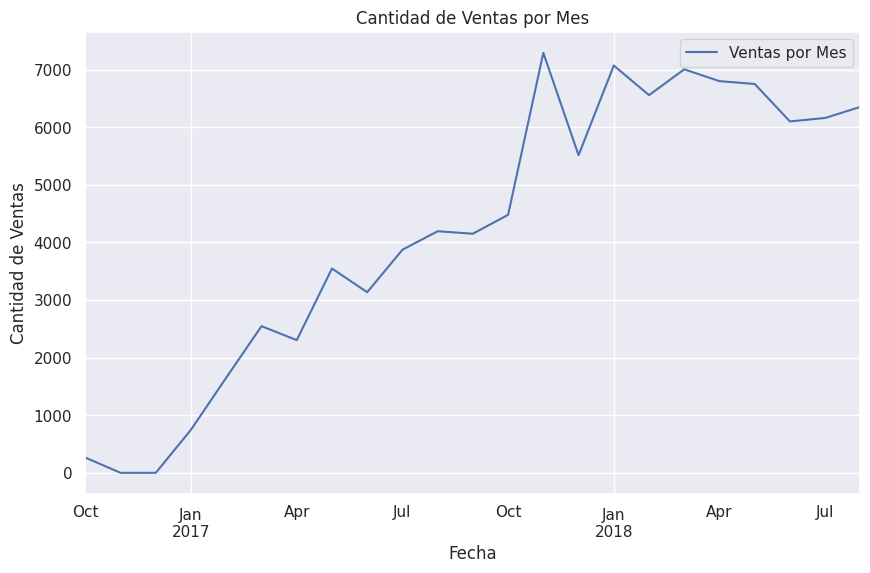

In [ ]:
# Copiar el DataFrame para conservar el original
df_copia = dfventas.copy()

# Convertir la columna 'order_purchase_timestamp' a tipo datetime y establecerla como el índice
df_copia['order_purchase_timestamp'] = pd.to_datetime(df_copia['order_purchase_timestamp'])
df_copia.set_index('order_purchase_timestamp', inplace=True)

# Graficar compras por mes y por año utilizando el índice como el eje x
plt.figure(figsize=(10, 6))
df_copia.resample('M').size().plot(label='Ventas por Mes')
plt.title('Cantidad de Ventas por Mes')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ventas')
plt.legend()
plt.grid(True)
plt.show()


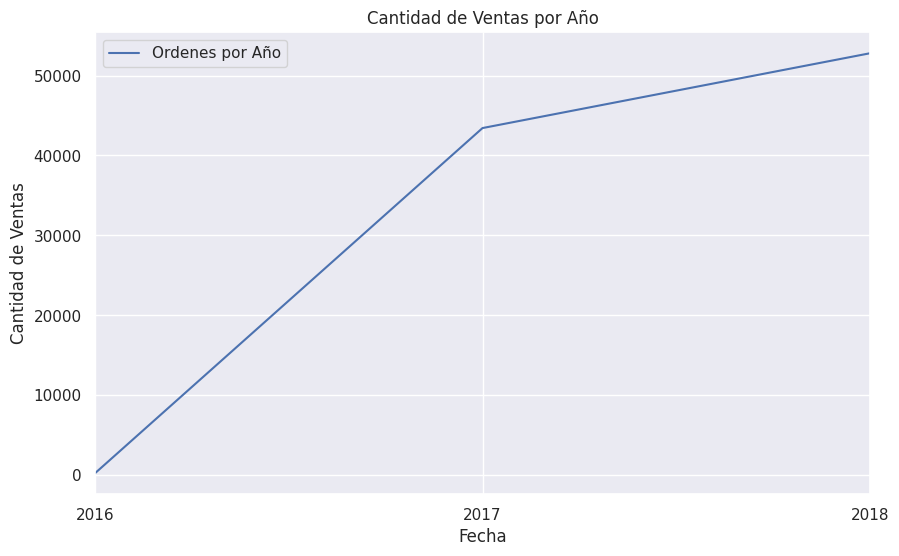

In [ ]:
plt.figure(figsize=(10, 6))
df_copia.resample('Y').size().plot(label='Ordenes por Año')
plt.title('Cantidad de Ventas por Año')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ventas')
plt.legend()
plt.grid(True)
plt.show()

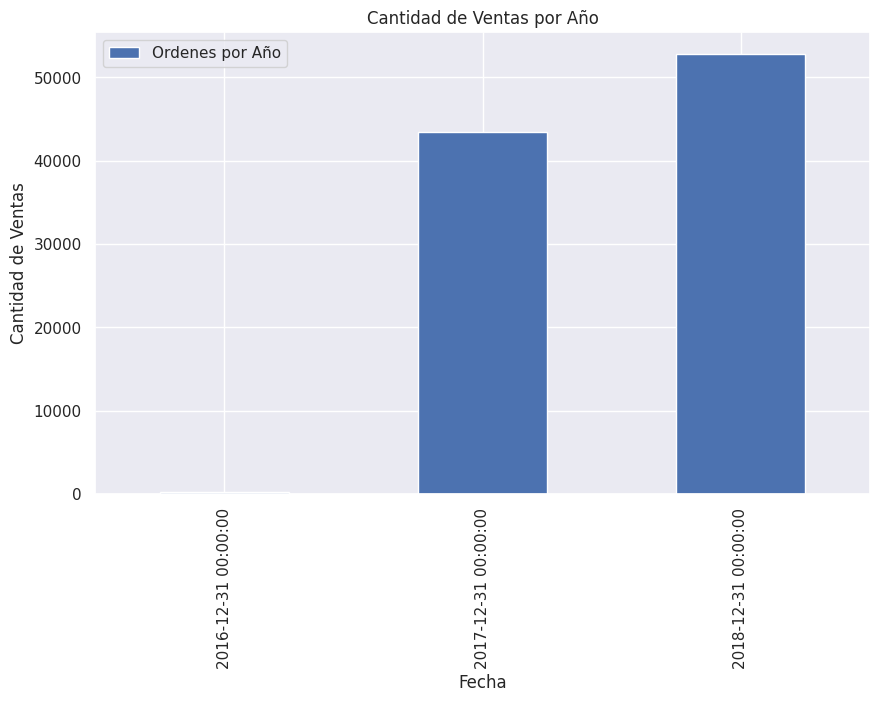

In [ ]:
plt.figure(figsize=(10, 6))
# Calcular el recuento de órdenes por año y graficar como un gráfico de barras
df_copia.resample('Y').size().plot(kind='bar', label='Ordenes por Año')
plt.title('Cantidad de Ventas por Año')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ventas')
plt.legend()
plt.grid(True)
plt.show()

## Series de tiempo

Preparación de los Datos: Agruparemos los datos por mes. Esto se hace para obtener una serie temporal más manejable y para ayudar a revelar patrones estacionales o tendencias.

Revisión de la Estacionariedad: Realizaremos pruebas de estacionariedad, como la prueba de Dickey-Fuller aumentada, para determinar si es necesario diferenciar los datos para hacerlos estacionarios.

Identificación de los Parámetros ARIMA: Utilizaremos las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los parámetros p, d, y q del modelo ARIMA.

Ajuste del Modelo ARIMA: Ajustaremos un modelo ARIMA con los parámetros identificados a los datos.

Predicciones: Realizaremos predicciones para los próximos años.

In [ ]:
df = dfventas.copy()

In [ ]:
df

,order_id,order_purchase_timestamp,pago_orden
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,28.62
...,...,...,...
99435,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,85.08
99436,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,195.00
99437,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,271.01
99438,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,441.16


**ARIMA**

Autoregresivo (AR) integrada (I) media móvil (MA) corresponde a uno de los modelos clásicos más empleados. Explica una serie de tiempo en función de sus propios valores pasados.

Comprende tres términos:

+ p: es el orden del término AR
+ q: es el orden del término MA
+ d: es el número de diferencias necesarias para que la serie sea estacionaria

Para aplicar este modelo, lo primero es hacer que la serie sea estacionaria. Esto se debe a que el término AR significa que el valor actual de la serie es una función lineal de los valores anteriores. Es decir, utiliza sus propios regazos como predictores.

Para hacer estacionaria la serie de tiempo, tenemos que encontrar el orden de diferenciación -el término **d**-.

Previamente, para identificar si la serie es estacionaria, utilizaremos la `prueba de Dickey-Fuller aumentada`. La hipótesis nula es que la serie no es estacionaria. Entonces, si **p** -el valor de la prueba- es menor que el nivel de significancia (0.05) se rechaza la hipótesis nula.

Mientras $P - Value > 0.05$ : seguimos buscando el orden de diferenciación.

In [ ]:
df['order_purchase_timestamp']= pd.to_datetime(df['order_purchase_timestamp']) # Convertimos a tipo de dato datetime
df.set_index('order_purchase_timestamp',inplace=True) # Seteamos la fecha como índice

In [ ]:
df.head

<bound method NDFrame.head of                                                   order_id  pago_orden
order_purchase_timestamp                                              
2017-10-02 10:56:33       e481f51cbdc54678b7cc49136f2d6af7       38.71
2018-07-24 20:41:37       53cdb2fc8bc7dce0b6741e2150273451      141.46
2018-08-08 08:38:49       47770eb9100c2d0c44946d9cf07ec65d      179.12
2017-11-18 19:28:06       949d5b44dbf5de918fe9c16f97b45f8a       72.20
2018-02-13 21:18:39       ad21c59c0840e6cb83a9ceb5573f8159       28.62
...                                                    ...         ...
2017-03-09 09:54:05       9c5dedf39a927c1b2549525ed64a053c       85.08
2018-02-06 12:58:58       63943bddc261676b46f01ca7ac2f7bd8      195.00
2017-08-27 14:46:43       83c1379a015df1e13d02aae0204711ab      271.01
2018-01-08 21:28:27       11c177c8e97725db2631073c19f07b62      441.16
2018-03-08 20:57:30       66dea50a8b16d9b4dee7af250b4be1a5       86.86

[96477 rows x 2 columns]>

In [ ]:
df.to_csv("dfindexado.csv")

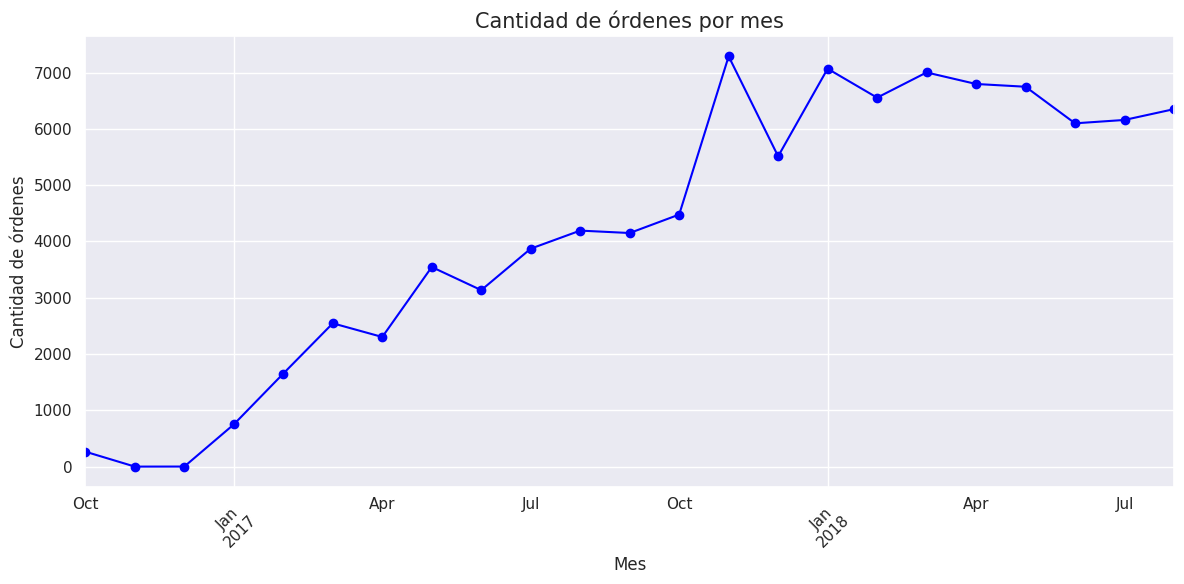

In [ ]:
# Contar la cantidad de órdenes por mes
orders_count_monthly = df['order_id'].resample('M').count()  # Agrupar por mes y contar órdenes

plt.figure(figsize=(12, 6))
orders_count_monthly.plot(kind='line', marker='o', color='blue')
plt.title('Cantidad de órdenes por mes', fontsize=15)
plt.xlabel('Mes')
plt.ylabel('Cantidad de órdenes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


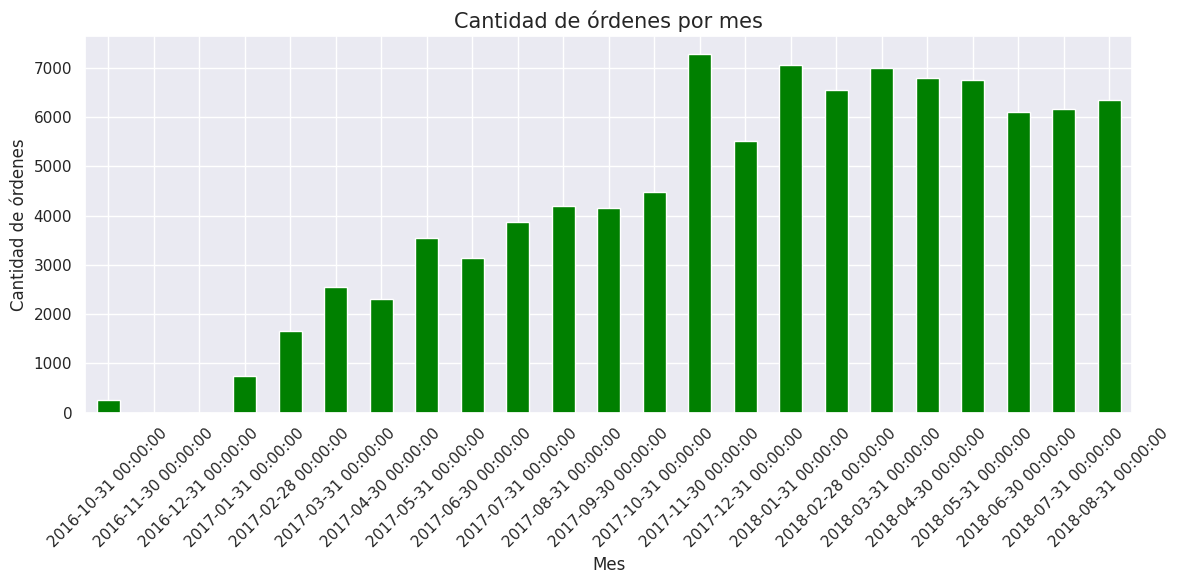

In [ ]:
# Contar la cantidad de órdenes por mes
orders_count_monthly = df['order_id'].resample('M').count()  # Agrupar por mes y contar órdenes

plt.figure(figsize=(12, 6))
orders_count_monthly.plot(kind='bar', color='green')
plt.title('Cantidad de órdenes por mes', fontsize=15)
plt.xlabel('Mes')
plt.ylabel('Cantidad de órdenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


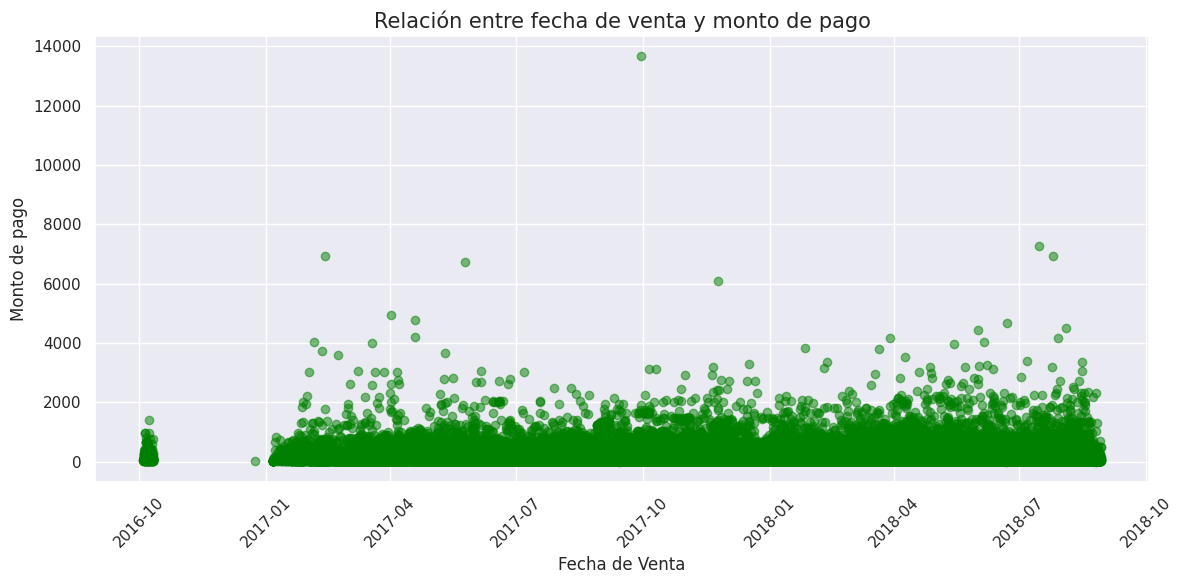

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['pago_orden'], color='green', alpha=0.5)
plt.title('Relación entre fecha de venta y monto de pago', fontsize=15)
plt.xlabel('Fecha de Venta')
plt.ylabel('Monto de pago')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Preparación de datos
agruparemos por mes para hacer el dataset más manejable y revelar patrones estacionales o tendencias.

In [ ]:
# Convertir el índice a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Agrupar por mes y sumar los valores
df_monthly = df.resample('M').sum()

df_monthly.head()

<ipython-input-37-148b74175927>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample('M').sum()


,pago_orden
order_purchase_timestamp,
2016-10-31,46566.71
2016-11-30,0.00
2016-12-31,19.62
2017-01-31,127545.67
2017-02-28,271298.65


In [ ]:
df_monthly

,pago_orden
order_purchase_timestamp,
2016-10-31,46566.71
2016-11-30,0.00
2016-12-31,19.62
2017-01-31,127545.67
2017-02-28,271298.65
2017-03-31,414369.39
2017-04-30,390952.18
2017-05-31,567066.73
2017-06-30,490225.60


In [ ]:
df_monthly.to_csv("monthly.csv")

In [ ]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 2016-10-31 to 2018-08-31
Freq: M
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pago_orden  23 non-null     float64
dtypes: float64(1)
memory usage: 368.0 bytes


### **Revisión de la Estacionariedad**
Después de agrupar los datos, realizamos la prueba de Dickey-Fuller aumentada para comprobar la estacionariedad.

 Es crucial que la serie temporal sea estacionaria para aplicar ARIMA, por lo que podemos usar la siguiente prueba:

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_monthly['pago_orden'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.8754310492648951
p-value: 0.343705906169381


El resultado de la prueba de Dickey-Fuller aumentada indica que la serie temporal probablemente no es estacionaria. Esto se deduce del hecho de que el valor de la estadística ADF es -1.8754 y el p-valor es 0.3437, que es mayor que el umbral común de 0.05. En análisis de series temporales, se busca un p-valor bajo para rechazar la hipótesis nula de que la serie tiene una raíz unitaria y que por ende no es estacionaria.

Para hacer la serie temporal estacionaria, se debe intentar diferenciarla. El siguiente paso sería diferenciar la serie y posiblemente identificar los parámetros óptimos de ARIMA mediante métodos como la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF).

### Diferenciación

La diferenciación es un método común para eliminar tendencias y estacionalidades en los datos. Vamos a diferenciar la serie temporal y luego volver a realizar la prueba de Dickey-Fuller.

Diferenciación de la Serie Temporal: Esto se hace restando el valor actual de la serie con su valor anterior.

Re-evaluación de la Estacionariedad: Realizar nuevamente la prueba de Dickey-Fuller en la serie diferenciada.

In [ ]:
df_monthly

,pago_orden
order_purchase_timestamp,
2016-10-31,46566.71
2016-11-30,0.00
2016-12-31,19.62
2017-01-31,127545.67
2017-02-28,271298.65
2017-03-31,414369.39
2017-04-30,390952.18
2017-05-31,567066.73
2017-06-30,490225.60


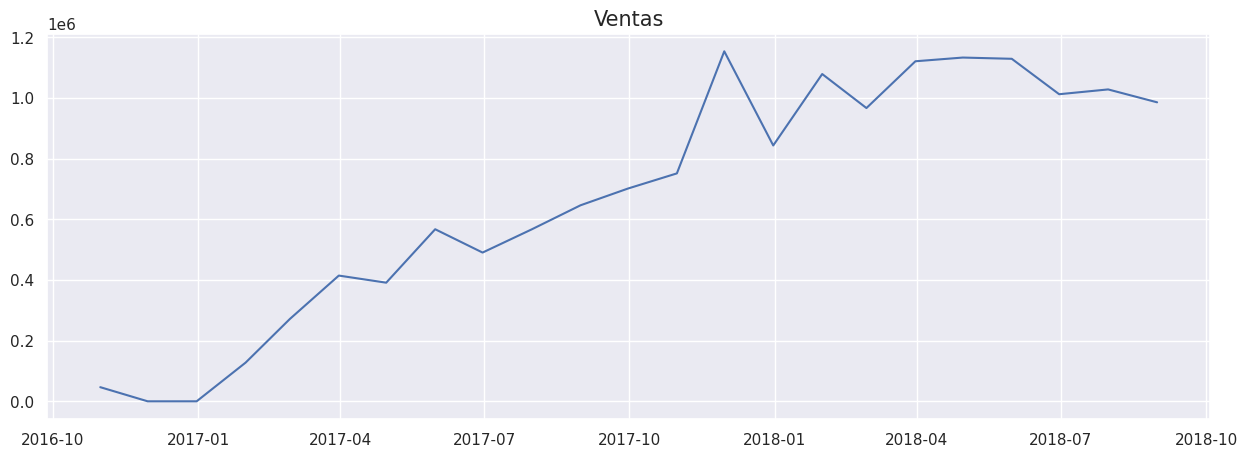

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Ventas', fontsize = 15)
plt.plot(df_monthly)
plt.show()

In [ ]:
# Diferenciación
df_diff = df_monthly['pago_orden'].diff().dropna()

# Realizar nuevamente la prueba de Dickey-Fuller
result_diff = adfuller(df_diff)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])


ADF Statistic: -8.220000663182038
p-value: 6.468068193113962e-13


 Estos resultados sugieren que la serie temporal diferenciada es estacionaria, ya que el p-valor es significativamente menor que el umbral común de 0.05.Con esto se puede asumir que la serie temporal es estacionaria después de una diferenciación.

In [ ]:
df_diff

order_purchase_timestamp
2016-11-30    -46566.71
2016-12-31        19.62
2017-01-31    127526.05
2017-02-28    143752.98
2017-03-31    143070.74
2017-04-30    -23417.21
2017-05-31    176114.55
2017-06-30    -76841.13
2017-07-31     76178.33
2017-08-31     79596.68
2017-09-30     55169.38
2017-10-31     49970.28
2017-11-30    402387.78
2017-12-31   -310328.88
2018-01-31    235407.69
2018-02-28   -112095.98
2018-03-31    154167.12
2018-04-30     12255.95
2018-05-31     -4097.26
2018-06-30   -116746.01
2018-07-31     15813.18
2018-08-31    -42489.58
Freq: M, Name: pago_orden, dtype: float64

### **Identificación de los Parámetros ARIMA:**
Debemos usar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) en la serie temporal diferenciada para identificar los parámetros p y q del modelo ARIMA. El parámetro
d ya lo hemos identificado como 1, debido a la diferenciación que hicimos.

**Forma manual**

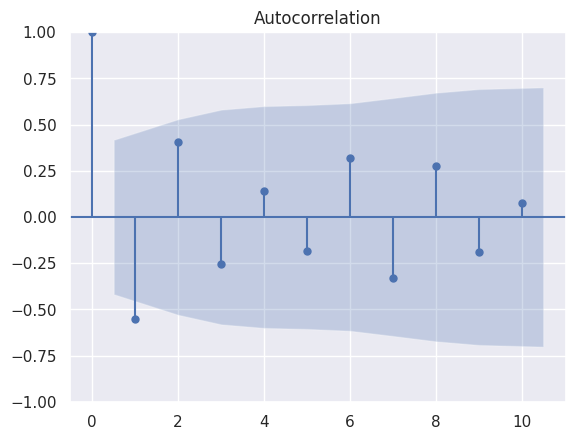

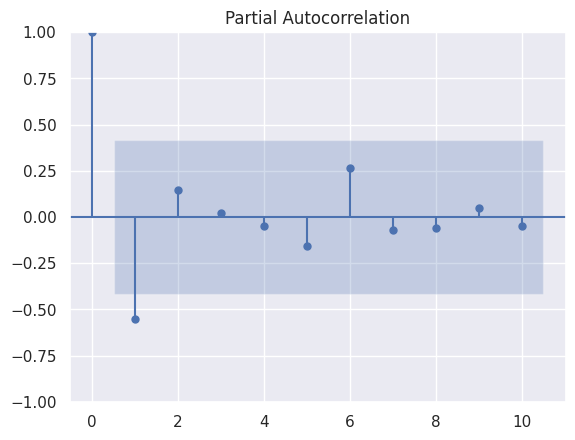

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Ajusta el número de retardos a un valor más bajo, por ejemplo, 10
lags = min(10, len(df_diff) // 2 - 1)

plot_acf(df_diff, lags=lags)
plot_pacf(df_diff, lags=lags)
plt.show()


Para seleccionar los parámetros p y q de un modelo ARIMA utilizando las gráficas de autocorrelación (ACF) y autocorrelación parcial (PACF), se debe buscar lo siguiente:
Autocorrelación Parcial (PACF): Identificar el último retraso significativo en la gráfica de PACF. Este retraso nos dará el valor de p para el modelo ARIMA. Un retraso significativo generalmente se muestra como un pico que cruza los límites de confianza (líneas azules en la gráfica).

Autocorrelación (ACF): De manera similar, identificar el último retraso significativo en la gráfica de ACF. Este retraso dará el valor de q para el modelo ARIMA.

En resumen, si leemos el gráfico se puede ver que:

Para p: Observamos la gráfica de PACF y buscamos el punto donde los picos cruzan el umbral de significancia por primera vez y después se vuelven insignificantes (se mantienen dentro del área sombreada). En la gráfica de PACF, parece que el primer pico significativo está en el retraso 1, después de lo cual los picos están dentro del área sombreada.

Para q: Observamos la gráfica de ACF y buscamos el primer pico significativo que cruza el umbral de significancia. En la gráfica de ACF, parece que no hay picos que sobresalgan claramente del área sombreada después del retraso 0, lo que sugiere que q podría ser 0.

Por lo tanto, una primera aproximación para los parámetros del modelo ARIMA, basada en estas gráficas, sería  p=1 y q=0. El parámetro d ya fue establecido como 1 debido a que la serie temporal se hizo estacionaria después de una diferenciación.

Entonces, se podria seguir el analisis probando un modelo ARIMA(1,1,0) en los datos.

Pero esto fue un análisis manual.
Se pueden utilizar métodos automáticos para seleccionar los parámetros p, q y d de un modelo ARIMA sin la necesidad de interpretar los gráficos ACF y PACF manualmente. Un enfoque común es utilizar criterios de información como el Akaike Information Criterion (AIC) o el Bayesian Information Criterion (BIC), que miden la calidad del modelo estadístico y penalizan la complejidad del modelo.

En Python, la biblioteca statsmodels tiene la función auto_arima proporcionada por la biblioteca pmdarima, que realiza esta tarea automáticamente, probando diferentes combinaciones de parámetros p, q y d seleccionando el modelo con el valor más bajo de AIC o BIC.

**Forma automática**

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

# Ejecutar auto_arima para seleccionar los mejores parámetros p, d, q
model_auto = auto_arima(df_diff, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)

# Los parámetros óptimos están en model_auto
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=588.086, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=588.190, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=586.327, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=588.179, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=585.522, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=586.725, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=585.957, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=586.829, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=587.953, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=584.143, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=582.373, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=588.275, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=584.122, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=586.706, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=586.0

El análisis automático seleccionó un modelo ARIMA(1,0,0) con un término de intercepción como el mejor modelo basado en el criterio AIC.

#### **Ajuste del Modelo ARIMA 100**

Con los parámetros p, d, y q identificados, se puede ajustar un modelo ARIMA a los datos.
order=(p, d, q))

In [ ]:
# Ajustar el modelo ARIMA(1,0,0) con intercepción a los datos originales (no diferenciados)
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_diff, order=(1, 0, 0))
model_fit = model.fit()

**Predicciones**:
Finalmente, se pueden realizar predicciones para los próximos años.

In [ ]:
# Hacer predicciones
predicciones = model_fit.get_prediction(start=pd.to_datetime('2018-09-01'),
                                        end=pd.to_datetime('2026-12-31'),
                                        dynamic=False)
prediccion = predicciones.predicted_mean

In [ ]:
prediccion.head(30)

2018-09-30    88976.865537
2018-10-31    17501.563258
2018-11-30    56361.051814
2018-12-31    35234.035870
2019-01-31    46720.311662
2019-02-28    40475.485989
2019-03-31    43870.655006
2019-04-30    42024.779195
2019-05-31    43028.339693
2019-06-30    42482.726783
2019-07-31    42779.364054
2019-08-31    42618.089148
2019-09-30    42705.770629
2019-10-31    42658.100212
2019-11-30    42684.017528
2019-12-31    42669.926875
2020-01-31    42677.587641
2020-02-29    42673.422658
2020-03-31    42675.687064
2020-04-30    42674.455958
2020-05-31    42675.125283
2020-06-30    42674.761386
2020-07-31    42674.959228
2020-08-31    42674.851666
2020-09-30    42674.910145
2020-10-31    42674.878352
2020-11-30    42674.895637
2020-12-31    42674.886239
2021-01-31    42674.891349
2021-02-28    42674.888571
Freq: M, Name: predicted_mean, dtype: float64

Las predicciones están dadas como diferencias debido a la diferenciación de orden 1 en el modelo ARIMA(1,1,1). Para obtener el nivel real de ventas previstas, se debe sumar estas diferencias a la última observación conocida de los datos originales.

Los valores parecen fluctuar alrededor de cero y presentan una disminución en la magnitud de las fluctuaciones a medida que avanzamos en el tiempo. Esto es consistente con lo que esperaríamos de un modelo ARIMA en diferencias: las predicciones tienden a volver al nivel medio de la serie.

Al interpretar estas predicciones, es importante considerar que el modelo ARIMA se basa en la suposición de que las condiciones pasadas, como tendencias o patrones estacionales, continuarán en el futuro. Si hubo un cambio estructural en los datos después del final del período de entrenamiento (agosto de 2018), el modelo podría no capturar bien estas nuevas condiciones.

Para realizar una predicción con el modelo ARIMA y obtener los niveles de venta previstos, es necesario ajustar el modelo a los datos originales no diferenciados.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Asumiendo que df_monthly es tu DataFrame original con las fechas como índice

# Ajustar el modelo ARIMA(1,1,1) a los datos originales (no diferenciados)
model = ARIMA(df_monthly['pago_orden'], order=(1, 0, 0))
model_fit = model.fit()

# Hacer predicciones desde septiembre de 2018 hasta agosto de 2020
predicciones = model_fit.get_prediction(start=pd.to_datetime('2018-09-01'),
                                        end=pd.to_datetime('2026-12-31'),
                                        dynamic=False)
prediccion = predicciones.predicted_mean

# Mostrar las primeras predicciones
prediccion.head(30)

2018-09-30    967635.714563
2018-10-31    950860.975834
2018-11-30    935033.384996
2018-12-31    920099.463474
2019-01-31    906008.752240
2019-02-28    892713.641322
2019-03-31    880169.208937
2019-04-30    868333.069711
2019-05-31    857165.231464
2019-06-30    846627.960083
2019-07-31    836685.652030
2019-08-31    827304.714038
2019-09-30    818453.449609
2019-10-31    810101.951917
2019-11-30    802222.002758
2019-12-31    794786.977203
2020-01-31    787771.753643
2020-02-29    781152.628902
2020-03-31    774907.238151
2020-04-30    769014.479342
2020-05-31    763454.441904
2020-06-30    758208.339473
2020-07-31    753258.446417
2020-08-31    748588.037938
2020-09-30    744181.333569
2020-10-31    740023.443850
2020-11-30    736100.320022
2020-12-31    732398.706557
2021-01-31    728906.096370
2021-02-28    725610.688561
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# Aplicar un formato para que los números se muestren como flotantes con dos decimales
prediccion_formato_regular = prediccion.apply(lambda x: f'{x:.2f}')

prediccion_formato_regular.head(30)

2018-09-30    967635.71
2018-10-31    950860.98
2018-11-30    935033.38
2018-12-31    920099.46
2019-01-31    906008.75
2019-02-28    892713.64
2019-03-31    880169.21
2019-04-30    868333.07
2019-05-31    857165.23
2019-06-30    846627.96
2019-07-31    836685.65
2019-08-31    827304.71
2019-09-30    818453.45
2019-10-31    810101.95
2019-11-30    802222.00
2019-12-31    794786.98
2020-01-31    787771.75
2020-02-29    781152.63
2020-03-31    774907.24
2020-04-30    769014.48
2020-05-31    763454.44
2020-06-30    758208.34
2020-07-31    753258.45
2020-08-31    748588.04
2020-09-30    744181.33
2020-10-31    740023.44
2020-11-30    736100.32
2020-12-31    732398.71
2021-01-31    728906.10
2021-02-28    725610.69
Freq: M, Name: predicted_mean, dtype: object

Estas predicciones representan el nivel de ventas esperado para cada mes, basándose en el patrón histórico capturado por el modelo ARIMA. El modelo predice que las ventas se mantendrán alrededor de 1 millón con ligeras fluctuaciones mes a mes.

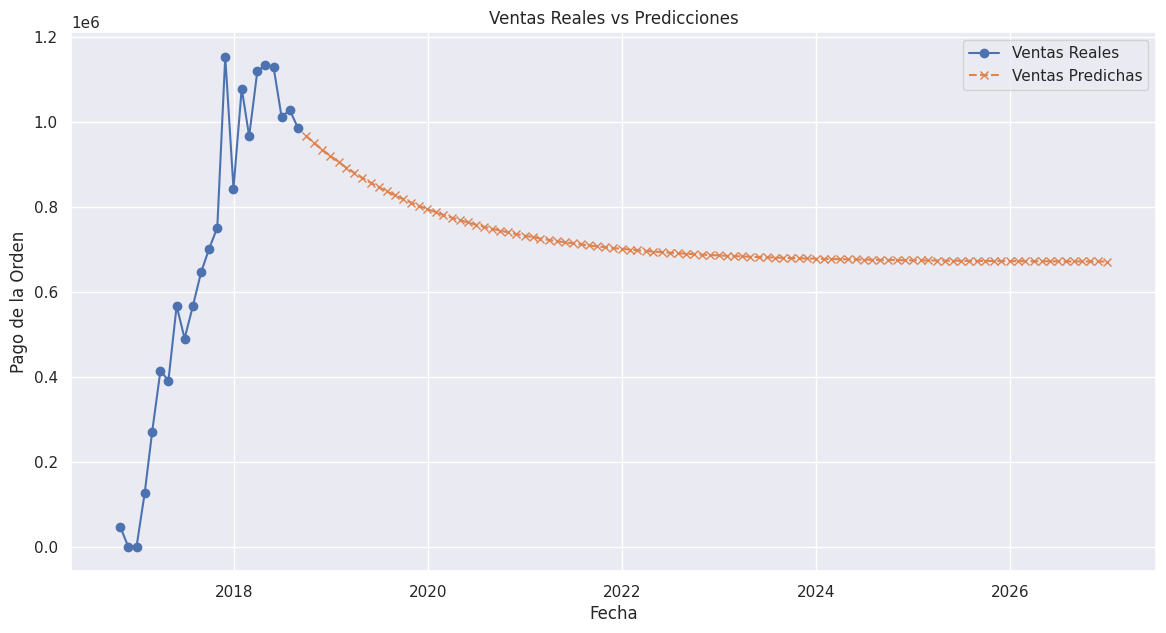

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir las predicciones a un formato numérico regular (no notación científica)
prediccion_formato_regular = prediccion.apply(lambda x: f'{x:.2f}')

# Convertir la serie de predicciones en un DataFrame para la graficación
prediccion_df = pd.DataFrame(prediccion_formato_regular)
prediccion_df.index = pd.to_datetime(prediccion_df.index)
prediccion_df['predicted_mean'] = prediccion_df['predicted_mean'].astype(float)

# Graficar df_monthly y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['pago_orden'], label='Ventas Reales', marker='o')
plt.plot(prediccion_df['predicted_mean'], label='Ventas Predichas', marker='x', linestyle='--')
plt.title('Ventas Reales vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Pago de la Orden')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Obtener intervalo de confianza
#pred_conf = predicciones.conf_int()
#pred_conf

In [ ]:
#prediccion.to_csv("pred1.csv")

El análisis automático seleccionó un modelo ARIMA(1,0,0) con un término de intercepción como el mejor modelo basado en el criterio AIC.

#### **Ajuste del Modelo ARIMA 110**

Con los parámetros p, d, y q identificados, se puede ajustar un modelo ARIMA a los datos.
order=(p, d, q))

In [ ]:
# Ajustar el modelo ARIMA(1,0,0) con intercepción a los datos originales (no diferenciados)
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_diff, order=(1, 1, 0))
model_fit = model.fit()

**Predicciones**:
Finalmente, se pueden realizar predicciones para los próximos años.

In [ ]:
# Hacer predicciones
predicciones = model_fit.get_prediction(start=pd.to_datetime('2018-09-01'),
                                        end=pd.to_datetime('2020-08-31'),
                                        dynamic=False)
prediccion = predicciones.predicted_mean

In [ ]:
prediccion.head(30)

2018-09-30     4901.055271
2018-10-31   -33619.802256
2018-11-30    -2308.627461
2018-12-31   -27759.506024
2019-01-31    -7072.092541
2019-02-28   -23887.585788
2019-03-31   -10219.332220
2019-04-30   -21329.393213
2019-05-31   -12298.725568
2019-06-30   -19639.185550
2019-07-31   -13672.588741
2019-08-31   -18522.458853
2019-09-30   -14580.305419
2019-10-31   -17784.633234
2019-11-30   -15180.037315
2019-12-31   -17297.149013
2020-01-31   -15576.282482
2020-02-29   -16975.066315
2020-03-31   -15838.083187
2020-04-30   -16762.265040
2020-05-31   -16011.055919
2020-06-30   -16621.666419
2020-07-31   -16125.339667
2020-08-31   -16528.772370
Freq: M, Name: predicted_mean, dtype: float64

Las predicciones están dadas como diferencias debido a la diferenciación de orden 1 en el modelo ARIMA(1,1,1). Para obtener el nivel real de ventas previstas, se debe sumar estas diferencias a la última observación conocida de los datos originales.

Los valores parecen fluctuar alrededor de cero y presentan una disminución en la magnitud de las fluctuaciones a medida que avanzamos en el tiempo. Esto es consistente con lo que esperaríamos de un modelo ARIMA en diferencias: las predicciones tienden a volver al nivel medio de la serie.

Al interpretar estas predicciones, es importante considerar que el modelo ARIMA se basa en la suposición de que las condiciones pasadas, como tendencias o patrones estacionales, continuarán en el futuro. Si hubo un cambio estructural en los datos después del final del período de entrenamiento (agosto de 2018), el modelo podría no capturar bien estas nuevas condiciones.

Para realizar una predicción con el modelo ARIMA y obtener los niveles de venta previstos, es necesario ajustar el modelo a los datos originales no diferenciados.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Asumiendo que df_monthly es tu DataFrame original con las fechas como índice

# Ajustar el modelo ARIMA(1,1,1) a los datos originales (no diferenciados)
model = ARIMA(df_monthly['pago_orden'], order=(1, 1, 0))
model_fit = model.fit()

# Hacer predicciones desde septiembre de 2018 hasta agosto de 2020
predicciones = model_fit.get_prediction(start=pd.to_datetime('2018-09-01'),
                                        end=pd.to_datetime('2020-08-31'),
                                        dynamic=False)
prediccion = predicciones.predicted_mean

# Mostrar las primeras predicciones
prediccion.head(30)

2018-09-30    1.002962e+06
2018-10-31    9.957150e+05
2018-11-30    9.987081e+05
2018-12-31    9.974720e+05
2019-01-31    9.979825e+05
2019-02-28    9.977716e+05
2019-03-31    9.978587e+05
2019-04-30    9.978227e+05
2019-05-31    9.978376e+05
2019-06-30    9.978315e+05
2019-07-31    9.978340e+05
2019-08-31    9.978329e+05
2019-09-30    9.978334e+05
2019-10-31    9.978332e+05
2019-11-30    9.978333e+05
2019-12-31    9.978332e+05
2020-01-31    9.978333e+05
2020-02-29    9.978333e+05
2020-03-31    9.978333e+05
2020-04-30    9.978333e+05
2020-05-31    9.978333e+05
2020-06-30    9.978333e+05
2020-07-31    9.978333e+05
2020-08-31    9.978333e+05
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
# Aplicar un formato para que los números se muestren como flotantes con dos decimales
prediccion_formato_regular = prediccion.apply(lambda x: f'{x:.2f}')

prediccion_formato_regular.head(30)

2018-09-30    1002962.21
2018-10-31     995715.03
2018-11-30     998708.07
2018-12-31     997471.96
2019-01-31     997982.47
2019-02-28     997771.63
2019-03-31     997858.70
2019-04-30     997822.74
2019-05-31     997837.60
2019-06-30     997831.46
2019-07-31     997833.99
2019-08-31     997832.95
2019-09-30     997833.38
2019-10-31     997833.20
2019-11-30     997833.28
2019-12-31     997833.25
2020-01-31     997833.26
2020-02-29     997833.25
2020-03-31     997833.26
2020-04-30     997833.25
2020-05-31     997833.25
2020-06-30     997833.25
2020-07-31     997833.25
2020-08-31     997833.25
Freq: M, Name: predicted_mean, dtype: object

Estas predicciones representan el nivel de ventas esperado para cada mes, basándose en el patrón histórico capturado por el modelo ARIMA. El modelo predice que las ventas se mantendrán alrededor de 1 millón con ligeras fluctuaciones mes a mes.

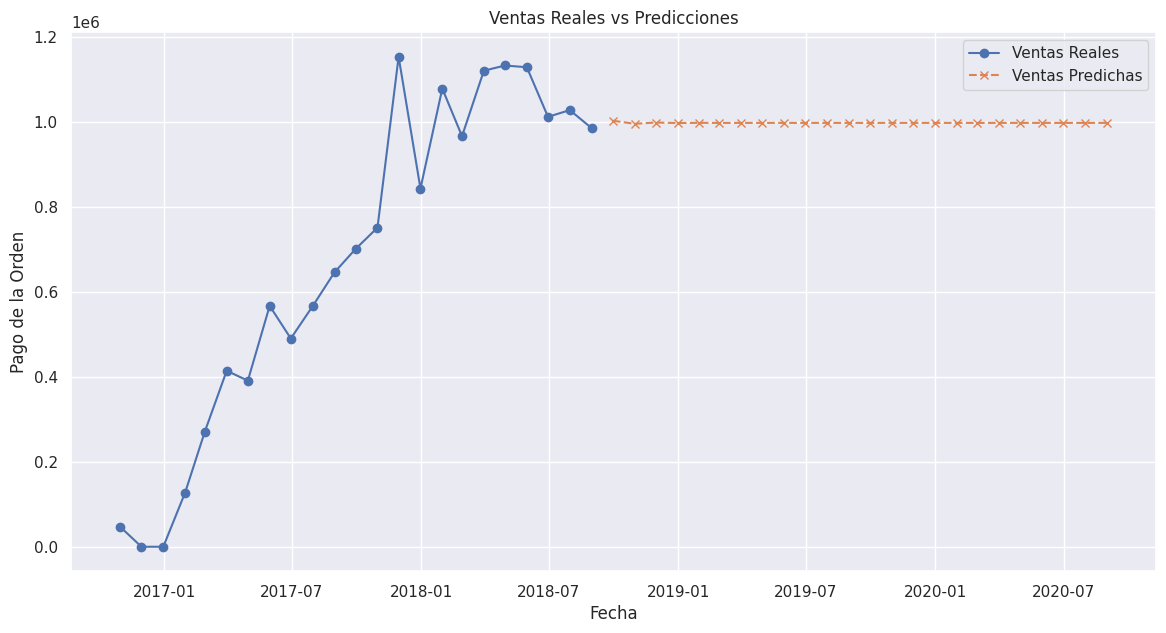

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir las predicciones a un formato numérico regular (no notación científica)
prediccion_formato_regular = prediccion.apply(lambda x: f'{x:.2f}')

# Convertir la serie de predicciones en un DataFrame para la graficación
prediccion_df = pd.DataFrame(prediccion_formato_regular)
prediccion_df.index = pd.to_datetime(prediccion_df.index)
prediccion_df['predicted_mean'] = prediccion_df['predicted_mean'].astype(float)

# Graficar df_monthly y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['pago_orden'], label='Ventas Reales', marker='o')
plt.plot(prediccion_df['predicted_mean'], label='Ventas Predichas', marker='x', linestyle='--')
plt.title('Ventas Reales vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Pago de la Orden')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Obtener intervalo de confianza
#pred_conf = predicciones.conf_int()
#pred_conf

In [ ]:
prediccion.to_csv("pred1.csv")

El análisis automático seleccionó un modelo ARIMA(1,0,0) con un término de intercepción como el mejor modelo basado en el criterio AIC.

### Optimización con Optuna

Ahora, procederemos a utilizar Optuna para optimizar aún más los parámetros del modelo ARIMA.

Para utilizar Optuna, definiremos una función objetivo que tomará los parámetros del modelo ARIMA, ajustará el modelo a tus datos y devolverá una métrica de rendimiento, como el AIC (Criterio de Información Akaike). El objetivo de Optuna será minimizar esta métrica.

In [ ]:
!pip install --quiet optuna

In [ ]:
import optuna
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
import optuna
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

# Suponiendo que df_monthly es tu DataFrame
# df_monthly = ...

def objective(trial):
    # Definir los rangos de los parámetros p, d, q
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    # Ajustar el modelo ARIMA
    try:
        model = ARIMA(df_diff, order=(p, d, q))
        model_fit = model.fit()
        aic = model_fit.aic
    except Exception as e:
        print(e)
        aic = np.inf

    return aic

In [ ]:
# Crear un estudio de Optuna y encontrar los mejores parámetros
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Puedes ajustar el número de pruebas

# Mejores parámetros
print('Mejores parámetros: ', study.best_params)

[I 2023-12-11 09:15:39,967] A new study created in memory with name: no-name-784cb6e1-e375-4f91-b815-fb26716034cc
[I 2023-12-11 09:15:40,059] Trial 0 finished with value: 584.1105108130571 and parameters: {'p': 1, 'd': 0, 'q': 1}. Best is trial 0 with value: 584.1105108130571.
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2023-12-11 09:15:40,892] Trial 1 finished with value: 563.6122712837401 and parameters: {'p': 2, 'd': 1, 'q': 4}. Best is trial 1 with value: 563.6122712837401.
[I 2023-12-11 09:15:41,257] Trial 2 finished with value: 589.9433919866063 and parameters: {'p': 4, 'd': 0, 'q': 1}. Best is trial 1 with value: 563.6122712837401.
[I 2023-12-11 09:15:41,392] Trial 3 finished with value: 586.0633247903912 and parameters: {'p': 2, 'd': 0, 'q': 1}. Best is trial 1 with value: 563.6122712837401.
/usr/loc

Mejores parámetros:  {'p': 2, 'd': 2, 'q': 3}


In [ ]:
# Ajustar y evaluar el modelo ARIMA con los mejores parámetros
best_p = study.best_params['p']
#best_d = study.best_params['d'] d no es necesaria aca porque ya usamos el df diferenciado.
best_q = study.best_params['q']
d = 0 # Diferenciación ya aplicada manualmente
model = ARIMA(df_diff, order=(best_p, d, best_q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             pago_orden   No. Observations:                   22
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -288.512
Date:                Mon, 11 Dec 2023   AIC                            591.024
Time:                        09:16:40   BIC                            598.662
Sample:                    11-30-2016   HQIC                           592.823
                         - 08-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.267e+04   3.69e+04      1.158      0.247   -2.96e+04    1.15e+05
ar.L1         -1.2329      7.535     -0.164      0.870     -16.000      13.535
ar.L2         -0.2805      5.381     -0.052      0.9

In [ ]:
#  predecir los próximos x períodos
predicciones = model_fit.get_forecast(steps=50)
pred_interval = predicciones.conf_int()

# Las predicciones
print(predicciones.predicted_mean)

# Intervalos de confianza
print(pred_interval)

2018-09-30    83885.465645
2018-10-31    -2450.340397
2018-11-30    80239.529745
2018-12-31     9016.579487
2019-01-31    73637.491438
2019-02-28    13940.298575
2019-03-31    69418.563987
2019-04-30    17760.986898
2019-05-31    65891.203395
2019-06-30    21038.389060
2019-07-31    62839.712943
2019-08-31    23881.451916
2019-09-30    60190.265379
2019-10-31    26350.642957
2019-11-30    57889.014832
2019-12-31    28495.391083
2020-01-31    55890.121055
2020-02-29    30358.350809
2020-03-31    54153.850805
2020-04-30    31976.547156
2020-05-31    52645.698787
2020-06-30    33382.138346
2020-07-31    51335.693844
2020-08-31    34603.057319
2020-09-30    50197.802610
2020-10-31    35663.567056
2020-11-30    49209.412096
2020-12-31    36584.742766
2021-01-31    48350.880295
2021-02-28    37384.890712
2021-03-31    47605.145850
2021-04-30    38079.912008
2021-05-31    46957.388991
2021-06-30    38683.618616
2021-07-31    46394.737028
2021-08-31    39208.007825
2021-09-30    45906.008540
2

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Asumiendo que df_monthly es tu DataFrame original con las fechas como índice

# Ajustar el modelo ARIMA(1,1,1) a los datos originales (no diferenciados)
model = ARIMA(df_monthly['pago_orden'], order=(2, 0, 3))
model_fit = model.fit()

# Hacer predicciones desde septiembre de 2018 hasta agosto de 2020
predicciones = model_fit.get_prediction(start=pd.to_datetime('2018-09-01'),
                                        end=pd.to_datetime('2026-12-31'),
                                        dynamic=False)
prediccionoptuna = predicciones.predicted_mean

# Mostrar las primeras predicciones
prediccionoptuna.head(30)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


2018-09-30    993750.719642
2018-10-31    957875.617046
2018-11-30    969500.852868
2018-12-31    918547.766008
2019-01-31    929127.939222
2019-02-28    884598.052653
2019-03-31    894211.149336
2019-04-30    855291.571640
2019-05-31    864012.647541
2019-06-30    829993.773171
2019-07-31    837894.433765
2019-08-31    808156.766843
2019-09-30    815304.827984
2019-10-31    789307.493735
2019-11-30    795766.785212
2019-12-31    773037.512028
2020-01-31    778867.793007
2020-02-29    758994.176130
2020-03-31    764251.137083
2020-04-30    746873.019297
2020-05-31    751608.349671
2020-06-30    736411.175605
2020-07-31    740672.680408
2020-08-31    727381.699549
2020-09-30    731213.451242
2020-10-31    719588.660831
2020-11-30    723031.175596
2020-12-31    712862.908596
2021-01-31    715953.338283
2021-02-28    707058.413807
Freq: M, Name: predicted_mean, dtype: float64

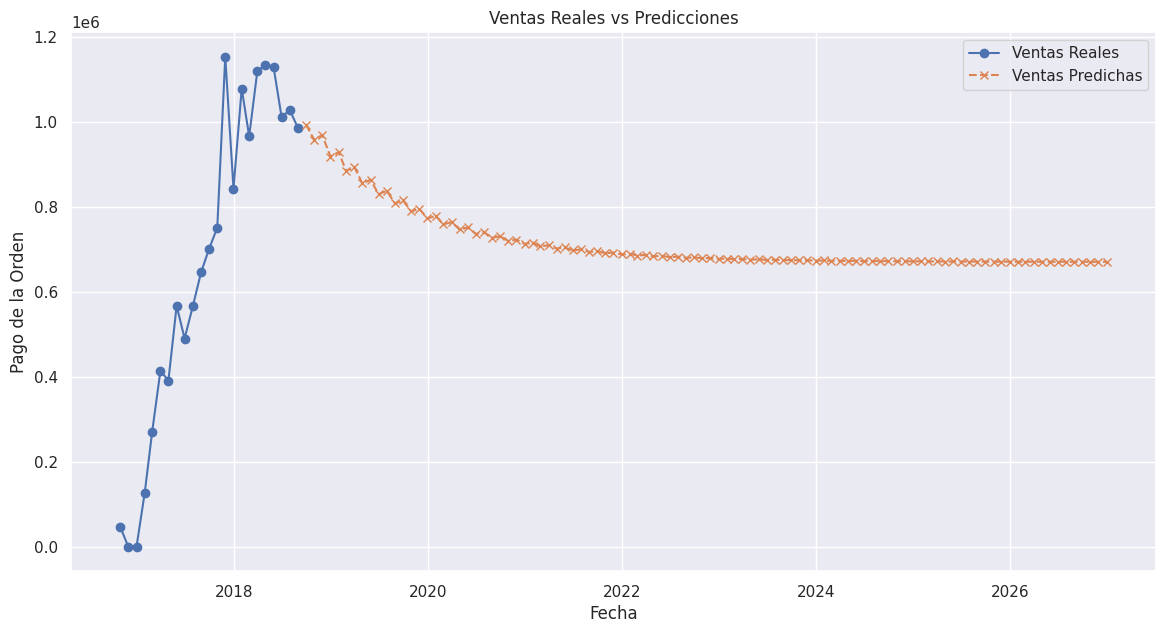

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir las predicciones a un formato numérico regular (no notación científica)
#prediccion_formato_regular = prediccion.apply(lambda x: f'{x:.2f}')

# Convertir la serie de predicciones en un DataFrame para la graficación
prediccionoptuna_df = pd.DataFrame(prediccionoptuna)
prediccionoptuna_df.index = pd.to_datetime(prediccion_df.index)
prediccionoptuna_df['predicted_mean'] = prediccionoptuna_df['predicted_mean'].astype(float)

# Graficar df_monthly y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(df_monthly['pago_orden'], label='Ventas Reales', marker='o')
plt.plot(prediccionoptuna_df['predicted_mean'], label='Ventas Predichas', marker='x', linestyle='--')
plt.title('Ventas Reales vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Pago de la Orden')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#df["forecast"].to_csv("solucion_1.csv")